In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import random
import numpy as np
from skimage import transform
from collections import OrderedDict
import json
from pathlib import Path
from torchvision import transforms
from sklearn.model_selection import train_test_split
import skimage.transform as skTrans

In [2]:
def crop_or_pad_slice_to_size(img_slice, nx, ny):
    slice_cropped = np.zeros((nx,ny))
    x, y = img_slice.shape
    
    x_s = (x-nx) // 2
    y_s = (y-ny) // 2
    x_c = (nx-x) // 2
    y_c = (ny-y) // 2
    
    if x > nx and y > ny:
        slice_cropped = img_slice[x_s:x_s+nx, y_s:y_s+ny]
    else :
        slice_cropped = np.zeros((nx, ny))
        if x <= nx and y > ny :
            slice_cropped[x_c:x_c+x, :] = img_slice[:, y_s:y_s + ny]
        elif x > nx and y <= ny:
            slice_cropped[:, y_c:y_c + y] = img_slice[x_s:x_s + nx, :]
        else:
            slice_cropped[x_c:x_c + x, y_c:y_c + y] = img_slice[:, :]

    return slice_cropped

def visualize_data(data_dir1, data_dir2, data_dir3, data_dir4) :    
    
    data = nib.load(data_dir1)
    image_data1 = data.get_fdata()
    
    data = nib.load(data_dir2)
    image_data2 = data.get_fdata()

    data = nib.load(data_dir3)
    image_data3 = data.get_fdata()
    
    data = nib.load(data_dir4)
    image_data4 = data.get_fdata()
    
    fig, axs = plt.subplots(2, 2)
    idx1 = int(image_data1.shape[2]/2)
    axs[0, 0].imshow(image_data1[:,:,idx1], cmap = "gray")
    axs[0, 0].set_title(image_data1.shape)
    idx2 = int(image_data2.shape[2]/2)
    axs[0, 1].imshow(image_data2[:,:,idx2], cmap = "gray")
    axs[0, 1].set_title(image_data2.shape)
    idx3 = int(image_data3.shape[2]/2)
    axs[1, 0].imshow(image_data3[:,:,idx3], cmap = "gray")
    axs[1, 0].set_title(image_data3.shape)
    idx4 = int(image_data4.shape[2]/2)
    axs[1, 1].imshow(image_data4[:,:,idx4], cmap = "gray")
    axs[1, 1].set_title(image_data4.shape)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

def visualize_data_2_channels(data_dir1, data_dir2, data_dir3, data_dir4, channel) :    
    data = nib.load(data_dir1)
    image_data1 = data.get_fdata()
    
    data = nib.load(data_dir2)
    image_data2 = data.get_fdata()

    data = nib.load(data_dir3)
    image_data3 = data.get_fdata()
    
    data = nib.load(data_dir4)
    image_data4 = data.get_fdata()
    
    print(image_data1.shape)
    fig, axs = plt.subplots(2, 2)
    idx1 = int(image_data1.shape[2]/2)
    axs[0, 0].imshow(image_data1[:,:,idx1,channel], cmap = "gray")
    axs[0, 0].set_title(image_data1.shape)
    idx2 = int(image_data2.shape[2]/2)
    axs[0, 1].imshow(image_data2[:,:,idx2,channel], cmap = "gray")
    axs[0, 1].set_title(image_data2.shape)
    idx3 = int(image_data3.shape[2]/2)
    axs[1, 0].imshow(image_data3[:,:,idx3,channel], cmap = "gray")
    axs[1, 0].set_title(image_data3.shape)
    idx4 = int(image_data4.shape[2]/2)
    axs[1, 1].imshow(image_data4[:,:,idx4,channel], cmap = "gray")
    axs[1, 1].set_title(image_data4.shape)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

In [3]:
def preprocess_data(img, config, pixel_size_target, pixel_size) :

    nx, ny = config["resize_size"]
    crop_size = config['crop_size']
    resize_size = config['resize_size']
    
    
    scale_vector = [pixel_size_target[0] / pixel_size[0], pixel_size_target[1] / pixel_size[1]]
    
    for slice_no in range(img.shape[2]) :
        slice_img = np.squeeze(img[:, :, slice_no])
        
        slice_rescaled = transform.rescale(slice_img,
                                          scale_vector,
                                          order= 1,
                                          preserve_range = True,
                                          mode = 'constant')
        
        slice_cropped = crop_or_pad_slice_to_size(slice_rescaled, crop_size[0], crop_size[1])
        
        slice_resized =  skTrans.resize(slice_cropped, resize_size, order=1, preserve_range=True)
       
        if(slice_no == 0) :
            cropped_img = np.reshape(slice_resized, (nx,ny,1))
        else :
            slice_cropped_tmp = np.reshape(slice_resized, (nx,ny,1))
            cropped_img = np.concatenate((cropped_img, slice_cropped_tmp), axis=2)
            
    return cropped_img

def find_pix_dim(vol_img) :
    
    pix_dim = vol_img.header['pixdim']
    dim = vol_img.header['dim']
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY]

def normalize_minmax_data(image_data,min_val=1,max_val=99):
    """
    # 3D MRI scan is normalized to range between 0 and 1 using min-max normalization.
    Here, the minimum and maximum values are used as 1st and 99th percentiles respectively from the 3D MRI scan.
    We expect the outliers to be away from the range of [0,1].
    input params :
        image_data : 3D MRI scan to be normalized using min-max normalization
        min_val : minimum value percentile
        max_val : maximum value percentile
    returns:
        final_image_data : Normalized 3D MRI scan obtained via min-max normalization.
    """
    min_val_1p=np.percentile(image_data,min_val)
    max_val_99p=np.percentile(image_data,max_val)
    final_image_data=np.zeros((image_data.shape[0],image_data.shape[1],image_data.shape[2]), dtype=np.float64)
    # min-max norm on total 3D volume
    final_image_data=(image_data-min_val_1p)/(max_val_99p-min_val_1p)
    
    return final_image_data

In [4]:
empty_files = ['/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/10/img.nii.gz',
              '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/14/img.nii.gz',
              '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/19/img.nii.gz',
              '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/02/5/img.nii.gz']


In [5]:
with open('configs/preprocessing_datasets.json') as config_file:
    config_datasets = json.load(config_file)
for dataset in config_datasets :
    if dataset['experiment'] == 'preprocessing' :
        if dataset['Data'] != 'CIMAS' and dataset['Data'] != 'ACDC'  :
            print(dataset["Data"])
            pix_dims = []
            X = []
            for path_image in Path(dataset['datadir']).rglob(dataset["name_img"]):
                img_data = nib.load(path_image)

                pix_dims.append(find_pix_dim(img_data))

            pixel_size_target = np.array(pix_dims).mean(axis = 0)
            print('mean pixel size : ', pixel_size_target)
            count = 0
            for path_image in Path(dataset['datadir']).rglob(dataset["name_img"]):
                if str(path_image) in empty_files :
                    continue
                print(path_image)
                img_data = nib.load(path_image)
                pixel_size = img_data.header['pixdim'][1:4]

                affine_img = img_data.affine
                img_data = img_data.get_fdata()

                if len(img_data.shape) > 3 :
                    img_cropped = preprocess_data(img_data[:,:,:,0], dataset, pixel_size_target, pixel_size)
                else :
                    img_cropped = preprocess_data(img_data, dataset, pixel_size_target, pixel_size )
                #print(img_cropped.shape)
                # Normalize input data
                img_normalized=normalize_minmax_data(img_cropped)
                img_normalized=np.clip(img_normalized, 0,1.5)
                #bin_counts, bin_edges, patches = plt.hist(img_normalized.ravel(),100)
                #plt.show()
                if np.sign(affine_img[0:2, 0:2]).trace() >= 0 :
                    affine_img[0,0]= pixel_size_target[0]
                    affine_img[1,1]= pixel_size_target[1]
                else :
                    affine_img[0,0]= -pixel_size_target[0]
                    affine_img[1,1]= -pixel_size_target[1]

                array_img = nib.Nifti1Image(img_normalized, affine_img)
                X.append(array_img)
                count += 1
                if dataset['Data'] == 'Medical Decathelon Brain 1' :
                    if count > 390 :
                        break

            #Split train validation test
            X_train, X_val = train_test_split(X, test_size=0.2, random_state=1)
            #X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

            index = 0
            for img in X_train :
                save_dir = dataset["savedir"] + 'train/subject_' +  str(index) 
                Path(save_dir).mkdir(parents = True, exist_ok = True)
                pred_filename = str(save_dir)+'/img.nii.gz'
                nib.save(img, pred_filename)
                index += 1
            index = 0
            for img in X_val :
                save_dir = dataset["savedir"] + 'validation/subject_' +  str(index) 
                Path(save_dir).mkdir(parents = True, exist_ok = True)
                pred_filename = str(save_dir)+'/img.nii.gz'
                nib.save(img, pred_filename)
                index += 1


Chaos
mean pixel size :  [0.7008609 0.7112776]
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/26/img.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/18/img.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/21/img.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/30/img.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/08/img.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/29/img.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/27/img.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/02/img.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/23/img.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/24/img.nii.gz
/usr/bmicnas01/data-biw

## Chaos

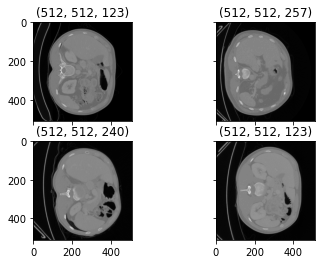

In [17]:
# Before

path = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/chaos/ct/'

data_dir1 = path + '08/img.nii.gz'
data_dir2 = path + '21/img.nii.gz'
data_dir3 = path + '23/img.nii.gz'
data_dir4 = path + '24/img.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

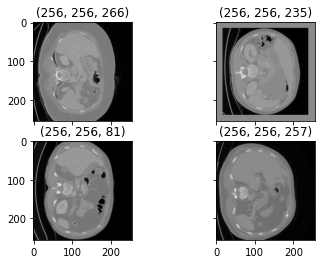

In [22]:
# After

path_dataset = '../img_cropped/chaos/validation/' 
data_dir1 = path_dataset + 'subject_0/img.nii.gz'
data_dir2 = path_dataset + 'subject_1/img.nii.gz'
data_dir3 = path_dataset + 'subject_2/img.nii.gz'
data_dir4 = path_dataset + 'subject_3/img.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

## ACDC

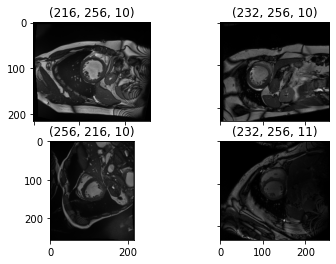

In [8]:
# Before

path = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/acdc_bias_corr/'
data_dir1 = path + 'patient001/patient001_frame01.nii.gz'
data_dir2 = path + 'patient004/patient004_frame01.nii.gz'
data_dir3 = path + 'patient005/patient005_frame01.nii.gz'
data_dir4 = path + 'patient006/patient006_frame01.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

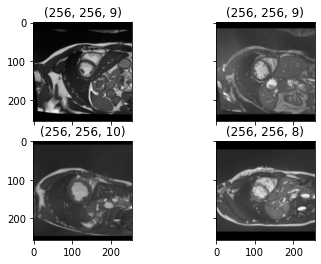

In [9]:
# After

path_dataset = '../img_cropped/acdc/train/' 
data_dir1 = path_dataset + 'subject_1/img.nii.gz'
data_dir2 = path_dataset + 'subject_2/img.nii.gz'
data_dir3 = path_dataset + 'subject_3/img.nii.gz'
data_dir4 = path_dataset + 'subject_4/img.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

## HCP

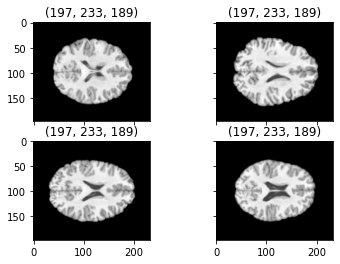

In [10]:
# Before 

path = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/HCP_brain_3T/'
data_dir1 = path + '100307/T1w_acpc_dc_restore_brain_onMNI.nii.gz'
data_dir2 = path + '100408/T1w_acpc_dc_restore_brain_onMNI.nii.gz'
data_dir3 = path + '135932/T1w_acpc_dc_restore_brain_onMNI.nii.gz'
data_dir4 = path + '188347/T1w_acpc_dc_restore_brain_onMNI.nii.gz'
visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

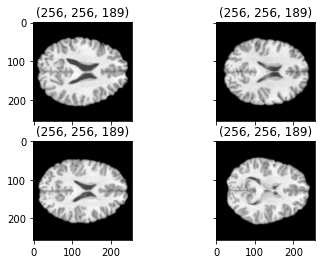

In [11]:
# After

path_dataset = '../img_cropped/HCP/train/' 
data_dir1 = path_dataset + 'subject_1/img.nii.gz'
data_dir2 = path_dataset + 'subject_2/img.nii.gz'
data_dir3 = path_dataset + 'subject_3/img.nii.gz'
data_dir4 = path_dataset + 'subject_4/img.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

## Medical Decathelon Lungs

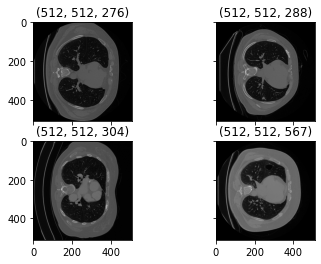

In [12]:
# Before

path = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/lungs_md/imagesTr/'
data_dir1 = path + 'lung_004.nii.gz'
data_dir2 = path + 'lung_003.nii.gz'
data_dir3 = path + 'lung_001.nii.gz'
data_dir4 = path + 'lung_006.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

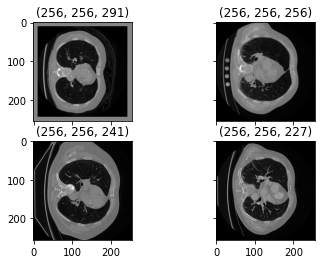

In [24]:
# After

path_dataset = '../img_cropped/medDecatLungs/train/' 
data_dir1 = path_dataset + 'subject_0/img.nii.gz'
data_dir2 = path_dataset + 'subject_1/img.nii.gz'
data_dir3 = path_dataset + 'subject_3/img.nii.gz'
data_dir4 = path_dataset + 'subject_4/img.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

## Medical Decathelon Prostate

(320, 320, 15, 2)


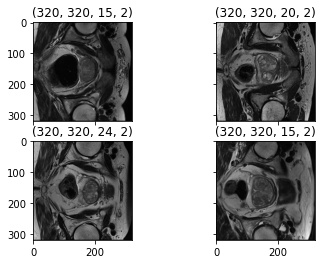

In [14]:
# Before

path = '../../../usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/Challenge_Datasets/prostate_md/'
data_dir1 = path + '000/img.nii.gz'
data_dir2 = path + '001/img.nii.gz'
data_dir3 = path + '002/img.nii.gz'
data_dir4 = path + '004/img.nii.gz'

visualize_data_2_channels(data_dir1, data_dir2,data_dir3, data_dir4,0)

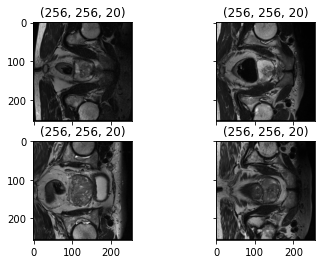

In [15]:
# After

path_dataset = '../img_cropped/medDecatProstate/train/' 
data_dir1 = path_dataset + 'subject_1/img.nii.gz'
data_dir2 = path_dataset + 'subject_2/img.nii.gz'
data_dir3 = path_dataset + 'subject_3/img.nii.gz'
data_dir4 = path_dataset + 'subject_4/img.nii.gz'

visualize_data(data_dir1, data_dir2,data_dir3, data_dir4)

In [16]:
#path_dataset = 'img_cropped/img_cropped_acdc/train/' 
#data_dir1 = path_dataset + 'patient_1/img_cropped.nii.gz'
data = nib.load(data_dir1)
image_data1 = data.get_fdata()
min_val=1
max_val=99
min_val_1p=np.percentile(image_data1,min_val)
max_val_99p=np.percentile(image_data1,max_val)
print(np.max(image_data1))
#final_image_data=np.zeros((image_data.shape[0],image_data.shape[1],image_data.shape[2]), dtype=np.float64)
#min-max norm on total 3D volume
#final_image_data=(image_data-min_val_1p)/(max_val_99p-min_val_1p)

1.5
